In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sunraster.instr.spice import read_spice_l2_fits
import h5py
import sunpy 
import sunpy.map
from sharpesst.correct_2d_psf import get_fwd_matrices, correct_spice_raster
from sharpesst.util import bindown, as_dict, get_iris_data, masked_median_filter, get_mask_errs
from sharpesst.fit_spice_lines import get_overall_center, fit_spice_lines as fsl
import astropy
from astropy.visualization import (ImageNormalize, AsinhStretch)
from astropy import constants as const
import juanfit
import importlib
importlib.reload(juanfit)
from juanfit import SpectrumFit2D
plt.style.use('science')

from copy import deepcopy
import os
from glob import glob
from pathlib import Path

In [2]:
fit_results = sorted(glob('../sav/CIII_20230330/*.h5'))
fit_results

['../sav/CIII_20230330/spice_1024_parameter_scan_core_large_bin_1.00_0.47_wing_10.00_2.50.h5',
 '../sav/CIII_20230330/spice_1024_parameter_scan_core_large_bin_1.00_0.47_wing_12.50_3.12.h5',
 '../sav/CIII_20230330/spice_1024_parameter_scan_core_large_bin_1.00_0.47_wing_15.00_3.75.h5',
 '../sav/CIII_20230330/spice_1024_parameter_scan_core_large_bin_1.00_0.47_wing_5.00_1.25.h5',
 '../sav/CIII_20230330/spice_1024_parameter_scan_core_large_bin_1.00_0.47_wing_7.50_1.88.h5',
 '../sav/CIII_20230330/spice_1024_parameter_scan_core_large_bin_1.50_0.71_wing_10.00_2.50.h5',
 '../sav/CIII_20230330/spice_1024_parameter_scan_core_large_bin_1.50_0.71_wing_12.50_3.12.h5',
 '../sav/CIII_20230330/spice_1024_parameter_scan_core_large_bin_1.50_0.71_wing_15.00_3.75.h5',
 '../sav/CIII_20230330/spice_1024_parameter_scan_core_large_bin_1.50_0.71_wing_5.00_1.25.h5',
 '../sav/CIII_20230330/spice_1024_parameter_scan_core_large_bin_1.50_0.71_wing_7.50_1.88.h5',
 '../sav/CIII_20230330/spice_1024_parameter_scan_core_

In [60]:
spice_raster = read_spice_l2_fits("../src/solo_L2_spice-n-ras_20230330T104824_V03_18454953.fits")
spice_CIII_977_window = spice_raster["C III 977 - Peak"]

spice_dat = deepcopy(spice_CIII_977_window.data[0])
specmin = np.nanmin(spice_CIII_977_window.data[0], axis=2)
spice_dat = spice_dat - specmin[:,:,np.newaxis]
spice_err_fac = np.nanstd(spice_dat[:,120:700,:][np.where(spice_dat[:,120:700,:] < np.nanpercentile(spice_dat[:,120:700,:], 1.5))])
spice_dat = spice_dat - np.nanmedian(spice_dat[np.r_[0:4,14:],:,:], axis=0)[np.newaxis,:,:]
rebin_facs = [1,4,1]

spicedat_bindown = bindown(spice_dat[:,120:700,:],np.round(np.array(spice_dat[:,120:700,:].shape)/rebin_facs).astype(np.int32))
spice_dat1 = deepcopy(spicedat_bindown).transpose([2,1,0]).astype(np.float32)
CIII_977_window_wvl = spice_CIII_977_window.spectral_axis.to_value("Angstrom")

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-OBS to 60033.450282 from DATE-OBS.
Set MJD-BEG to 60033.450282 from DATE-BEG.
Set MJD-AVG to 60033.483893 from DATE-AVG.
Set MJD-END to 60033.517501 from DATE-END'. [astropy.wcs.wcs]
/tmp/ipykernel_25274/2619517550.py:5: RuntimeWarning: All-NaN slice encountered
  specmin = np.nanmin(spice_CIII_977_window.data[0], axis=2)
/tmp/ipykernel_25274/2619517550.py:8: RuntimeWarning: All-NaN slice encountered
  spice_dat = spice_dat - np.nanmedian(spice_dat[np.r_[0:4,14:],:,:], axis=0)[np.newaxis,:,:]


In [48]:
spice_dat1.shape

(192, 145, 18)

In [66]:
spice_sdev_guess = 0.1
corr_sdev_guess = 0.05


spice_mask, spice_err = get_mask_errs(spice_dat1.astype(np.float64), spice_err_fac)
spice_la = spice_CIII_977_window.spectral_axis.to_value("Angstrom")
spice_wlcen0 = spice_la[np.nanargmax(np.nanmean(spice_dat1[:,:,:], axis=(0,1)))]

spice_fits = fsl(spice_dat1, spice_err, spice_la, spice_mask, spice_wlcen0, spice_sdev_guess)

/tmp/ipykernel_25274/1652488659.py:7: RuntimeWarning: Mean of empty slice
  spice_wlcen0 = spice_la[np.nanargmax(np.nanmean(spice_dat1[:,:,:], axis=(0,1)))]


0 of 192 0.0
10 of 192 0.0
20 of 192 0.0
30 of 192 0.0
40 of 192 0.0
50 of 192 0.0
60 of 192 0.0
70 of 192 0.0
80 of 192 0.0
90 of 192 0.0
100 of 192 0.0
110 of 192 0.0
120 of 192 0.0
130 of 192 0.0
140 of 192 0.0
150 of 192 0.0
160 of 192 0.0
170 of 192 0.0
180 of 192 0.0
190 of 192 0.0
191 of 192 0.0


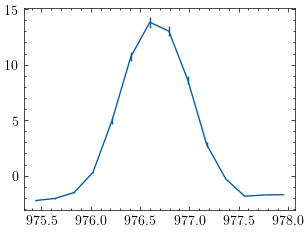

In [65]:
plt.errorbar(spice_la, spice_dat1[100,50,:], yerr=spice_err[100,50,:], )
plt.show()

In [62]:
spice_err

array([[[       nan, 0.01681902, 0.01681902, ...,        nan,
                nan,        nan],
        [       nan, 0.01681902, 0.01681902, ...,        nan,
                nan,        nan],
        [       nan, 0.01681902, 0.01681902, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 0.01681902,
         0.01681902,        nan],
        [       nan,        nan,        nan, ..., 0.01681902,
         0.01681902,        nan],
        [       nan,        nan,        nan, ..., 0.01681902,
         0.01681902,        nan]],

       [[       nan, 0.01681902, 0.01681902, ...,        nan,
                nan,        nan],
        [       nan, 0.01681902, 0.01681902, ...,        nan,
                nan,        nan],
        [       nan, 0.01681902, 0.01681902, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 0.01681902,
         0.01681902,        nan],
        [   

In [5]:
CIII_origin_fitmodel = SpectrumFit2D(spice_dat1[:,:,4:14].transpose([1,0,2]).astype(np.float32), CIII_977_window_wvl[4:14],
                                line_number=1,line_wvl_init=[977],int_max_init=0.2,fwhm_init=1,
                                same_width=False)
CIII_origin_fitmodel.run_lse_mp(prev_init=False,absolute_sigma=False)

/home/yjzhu/SOLAR/MyPy/juanfit.py:291: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,
/home/yjzhu/SOLAR/MyPy/juanfit.py:291: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,
/home/yjzhu/SOLAR/MyPy/juanfit.py:291: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,
/home/yjzhu/SOLAR/MyPy/juanfit.py:291: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,
/home/yjzhu/SOLAR/MyPy/juanfit.py:291: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,
/home/yjzh

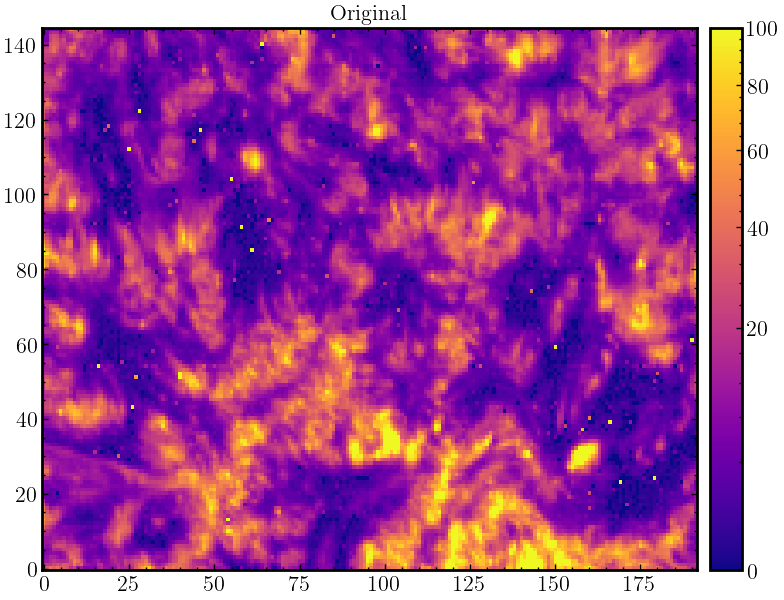

In [26]:
CIII_origin_fitmodel.plot_fit2d(param="int",vmin=0,vmax=100,scale="sqrt",
                                  aspect=1.098,cmap="plasma",
                                  title="Original")
plt.show()

Doppler velocity corrected by the median of each raster.


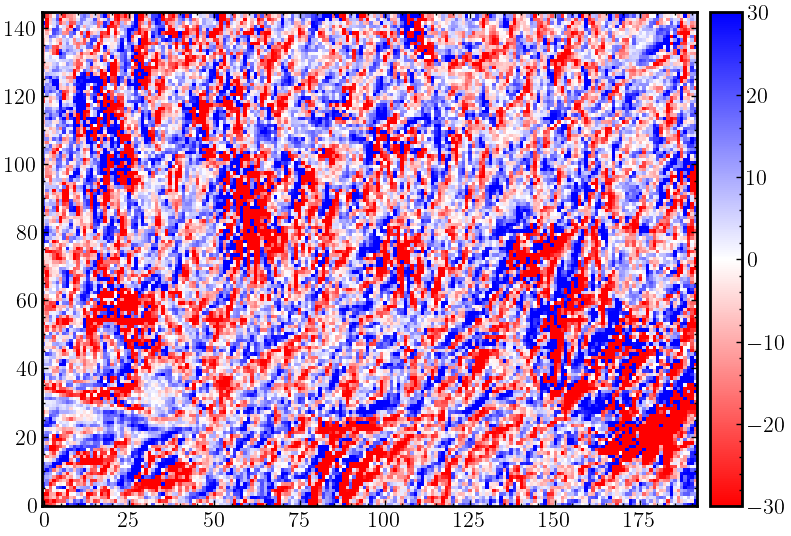

In [27]:
CIII_origin_fitmodel.plot_fit2d(param="vel",vmin=-30,vmax=30,vel_corr="column",ref_wvl=977.020,   
                                    aspect=1)
plt.show()

In [67]:
def fit_and_plot(fit_result_file, original_fit_model,save=False):
    with h5py.File(fit_result_file,"r") as hf:
        spice_corr_dat = hf["spice_corr_dat"][:]
        spice_corr_chi2s = hf["spice_corr_chi2s"][:]
        # fwhm_core_yl = hf.attrs["fwhm_core_yl"]
        # fwhm_wing_yl = hf.attrs["fwhm_wing_yl"]


    CIII_deconv_rebin_fitmodel = SpectrumFit2D(spice_corr_dat[:,:,4:14].transpose([1,0,2]).astype(np.float32), CIII_977_window_wvl[4:14],
                                line_number=1,line_wvl_init=[977],int_max_init=0.2,fwhm_init=1,
                                same_width=False)
    CIII_deconv_rebin_fitmodel.run_lse_mp(prev_init=False,absolute_sigma=False)

    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,8),constrained_layout=True)

    original_fit_model.plot_fit2d(param="int",vmin=0,vmax=100,scale="sqrt",
                                  aspect=1.098,ax=ax1,cmap="plasma",
                                  title="Original")

    CIII_deconv_rebin_fitmodel.plot_fit2d(param="int",vmin=0,vmax=100,scale="sqrt",
                                  aspect=1.098,ax=ax2,cmap="plasma",
                                  title="Deconvolved")
    
    ax2.plot(spice_corr_chi2s.T)

    original_fit_model.plot_fit2d(param="vel",vmin=-30,vmax=30,ref_wvl=977.02,   
                                    aspect=1.098,ax=ax3)
    
    CIII_deconv_rebin_fitmodel.plot_fit2d(param="vel",vmin=-30,vmax=30,ref_wvl=977.02,   
                                    aspect=1.098,ax=ax4)
    
    # fwhm_core_fac = np.float32(os.path.basename(fit_result_file).split("_")[7:9])
    # fwhm_wing_fac = np.float32(os.path.basename(fit_result_file).split("_")[10].split(".h5")[0])

    fwhm_core_yl = np.float32(Path(fit_result_file).stem.split("_")[7:9])
    fwhm_wing_yl = np.float32(Path(fit_result_file).stem.split("_")[10:])
    
    fig.suptitle(r"Core: {:.2f}\,arcsec {:.2f}\,\AA\quad Wing: {:.2f}\,arcsec {:.2f}\,\AA".format(*fwhm_core_yl,*fwhm_wing_yl),
                 fontsize=14)

    if save is True:
        plt.savefig(fname=os.path.join("../figs/CIII_20230330",os.path.basename(fit_result_file).replace(".h5",".png")),
                    dpi=200)
        fig.clf()
        plt.close()
    else:
        plt.show()
                    

In [29]:
os.path.basename(fit_results[0]).split("_")[7].split(".h5")[0]

'1.00'

Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.


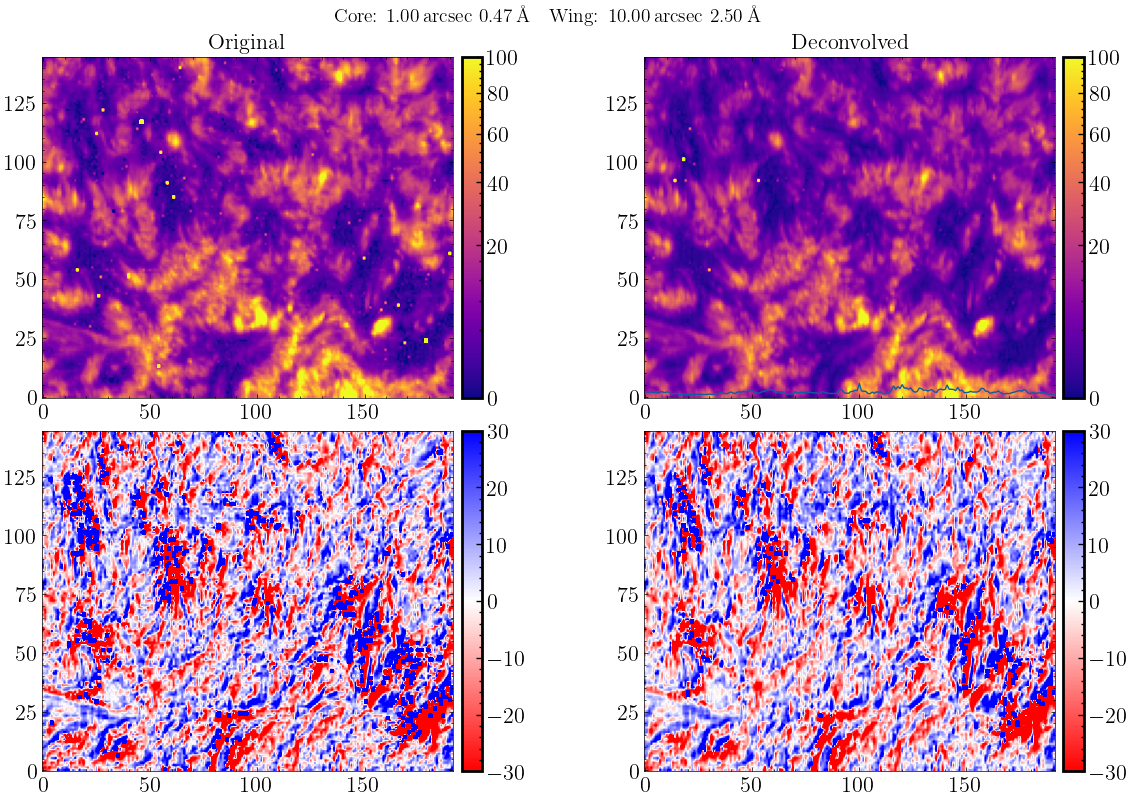

In [68]:
fit_and_plot(fit_results[0],CIII_origin_fitmodel)

In [69]:
for fit_result_ in fit_results:
    fit_and_plot(fit_result_,CIII_origin_fitmodel,save=True)

Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by t

/home/yjzhu/SOLAR/MyPy/juanfit.py:291: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,


Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.


/home/yjzhu/SOLAR/MyPy/juanfit.py:291: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,


Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
Doppler velocity corrected by the median of each raster.
